# Magnetic Field Maps

<script src="https://cdn.jsdelivr.net/gh/plexoos/pub-docs@0be43f5/assets/ipynb.js"></script>
 
<a id="toggle_all_input" href="#" data-show-input="false" onclick="toggleAllInput(this); return false;">Show/Hide input</a> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import RegularGridInterpolator

import uproot

In [2]:
rfile = uproot.open("/Users/dsmirnov/work/tpc-rs/data/sphenix3dmaprhophiz.root")

In [3]:
df = rfile['fieldmap'].pandas.df()

There are NaNs in the `brho` and `bphi` arrays where `rho = 0` and `phi = 0`. For now I replace these NaNs with zeros

In [4]:
df.isna().sum()

rho       0
phi       0
z         0
brho    101
bphi    101
bz        0
dtype: int64

In [5]:
df = df.fillna(0)

In [6]:
df.rename(columns={'rho': 'r', 'phi': 'p', 'brho': 'br', 'bphi': 'bp'}, inplace=True)

In [7]:
df.br *= 1000
df.bp *= 1000
df.bz *= 1000

Convert cylindrical `rho` and `phi` components into cartesian `x` and `y` 

In [8]:
df = df.assign(**{
    'x':  df.r*np.cos(df.p),
    'y':  df.r*np.sin(df.p),
    'bx': df.br*np.cos(df.p) - df.bp*np.sin(df.p),
    'by': df.br*np.sin(df.p) + df.bp*np.cos(df.p),
    'b':  np.sqrt(df.br**2 + df.bp**2 + df.bz**2),
})

In [9]:
dfc = df[['x', 'y', 'z', 'bx', 'by', 'bz', 'b', 'br', 'bp', 'r', 'p']].copy()

In [10]:
dfc = dfc.round({'x': 4, 'y': 4})

In [11]:
dfc.sort_values(['x', 'y', 'z'], inplace=True)

In [12]:
#dfc

In [13]:
#dfc.b.values.reshape(81,81,101)

In [14]:
#dfc.nunique()

In [15]:
#dfc[['x', 'y', 'z', 'r', 'p', 'bx', 'by', 'bz', 'br', 'bp']].describe()

In [16]:
#dfr.bphi.hist(bins=np.linspace(-0.01, 0.01, 101))

In [17]:
# Auxilary function to plot r vs phi
def plot_points(ax, df, zs, x_, y_):
    for i,z in enumerate(zs):
        indexer = (df.z == z)
        a = ax.ravel()[i] if type(ax) is np.ndarray else ax
        a.plot(df.loc[indexer][x_], df.loc[indexer][y_], '.', ms=0.5)
        a.set_xlabel(x_)
        a.set_ylabel(y_)
        a.grid(True)

    plt.tight_layout()
    plt.show()

def plot_slices(df, zs):
    ncols = min(3, len(zs))
    plot_width = min(4, 12/ncols)
    q, r = divmod(len(zs), ncols)
    nrows = q + 1 if r else q
 
    # Plot coordinates twice: in polar and cartesian coordinates
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(plot_width*ncols, plot_width*nrows), subplot_kw=dict(projection='polar'))
    plot_points(ax, df, zs, 'p', 'r')

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(plot_width*ncols, plot_width*nrows))
    plot_points(ax, df, zs, 'p', 'r')
 
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(plot_width*ncols, plot_width*nrows))
    plot_points(ax, df, zs, 'x', 'y')

Plot points of the magnetic field grid 

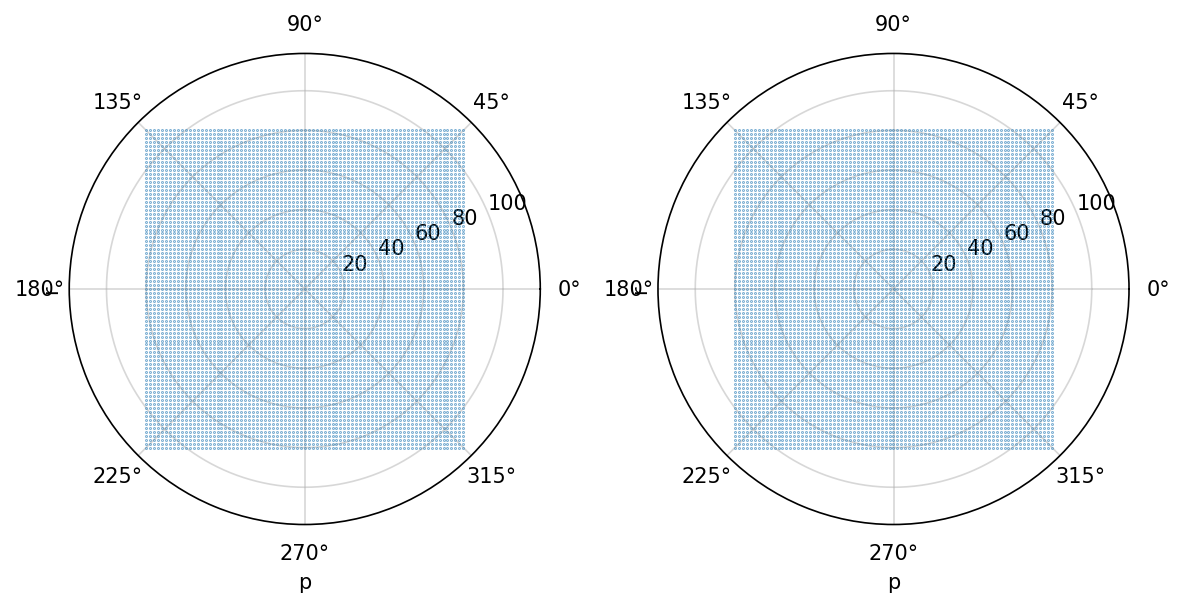

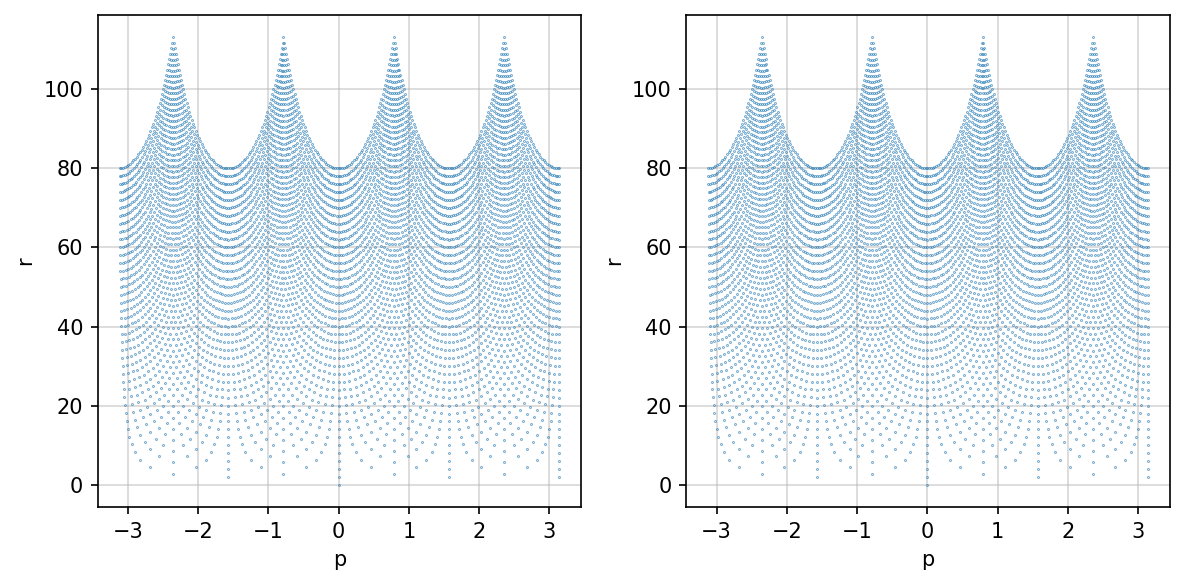

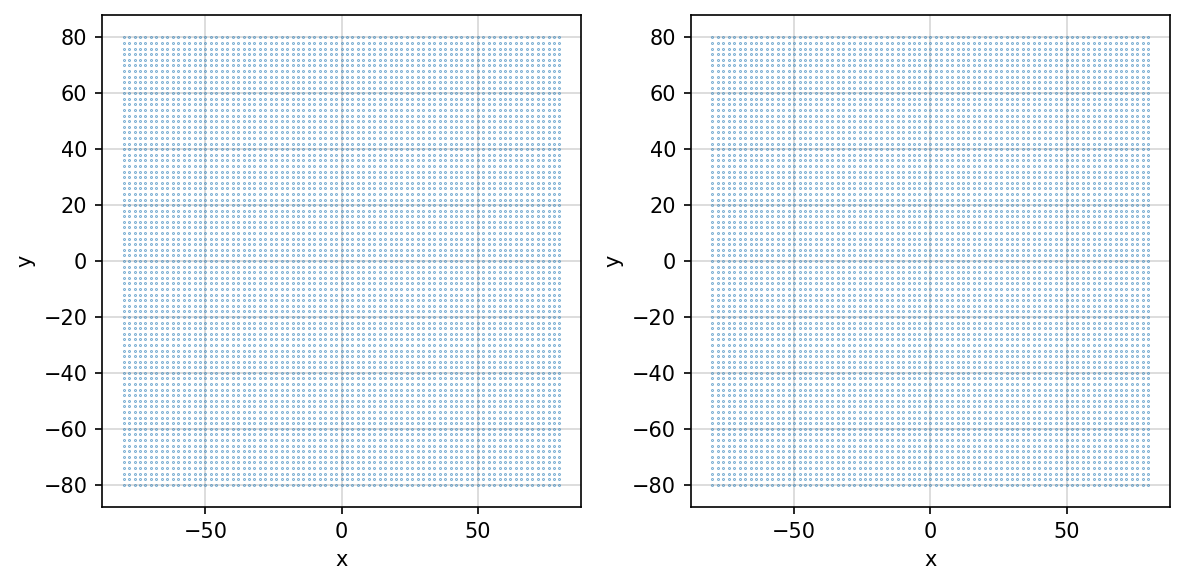

In [18]:
plot_slices(dfc, [-40,  40])

In [19]:
def fig_field_components(df, polar, z_slices, columns, axsize):
    nrows = len(z_slices)
    ncols = len(columns)
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(axsize[0]*ncols, axsize[1]*nrows),
                           subplot_kw=dict(projection='polar') if polar else None)
    
    if polar:
        p = np.linspace(0, 360, 145)/180*np.pi
        r = np.linspace(0, 80, 81)
        #yy, xx = np.meshgrid(r, p)
        xx, yy = np.meshgrid(p, r)
    else: 
        x = df.x.unique()
        y = df.y.unique()
        xx, yy = np.meshgrid(x, y)
    
    for irow, z in enumerate(z_slices):
        indexer = (df.z == z)
        
        for icol, (col, col_label) in enumerate({'br': '$B_r$, G', 'bp': '$B_\phi$, G', 'bz': '$B_z$, G'}.items()):
            a = ax[irow][icol]
            pcm = a.pcolormesh(xx, yy, df.loc[indexer][col].values.reshape(xx.shape))
            if not polar:
                a.xaxis.set_ticks(np.arange(-80, 80+1, 40))
                a.yaxis.set_ticks(np.arange(-80, 80+1, 40))
            #a.set_xlabel('$x$, cm') if irow == len(z_slices) - 1 else None
            a.set_ylabel(f'z = {z}') if icol == 0 else None
            a.set_title(col_label) if irow == 0 else None
            a.grid(True)
            cb = fig.colorbar(pcm, ax=a, pad=0.1)
 
    return fig

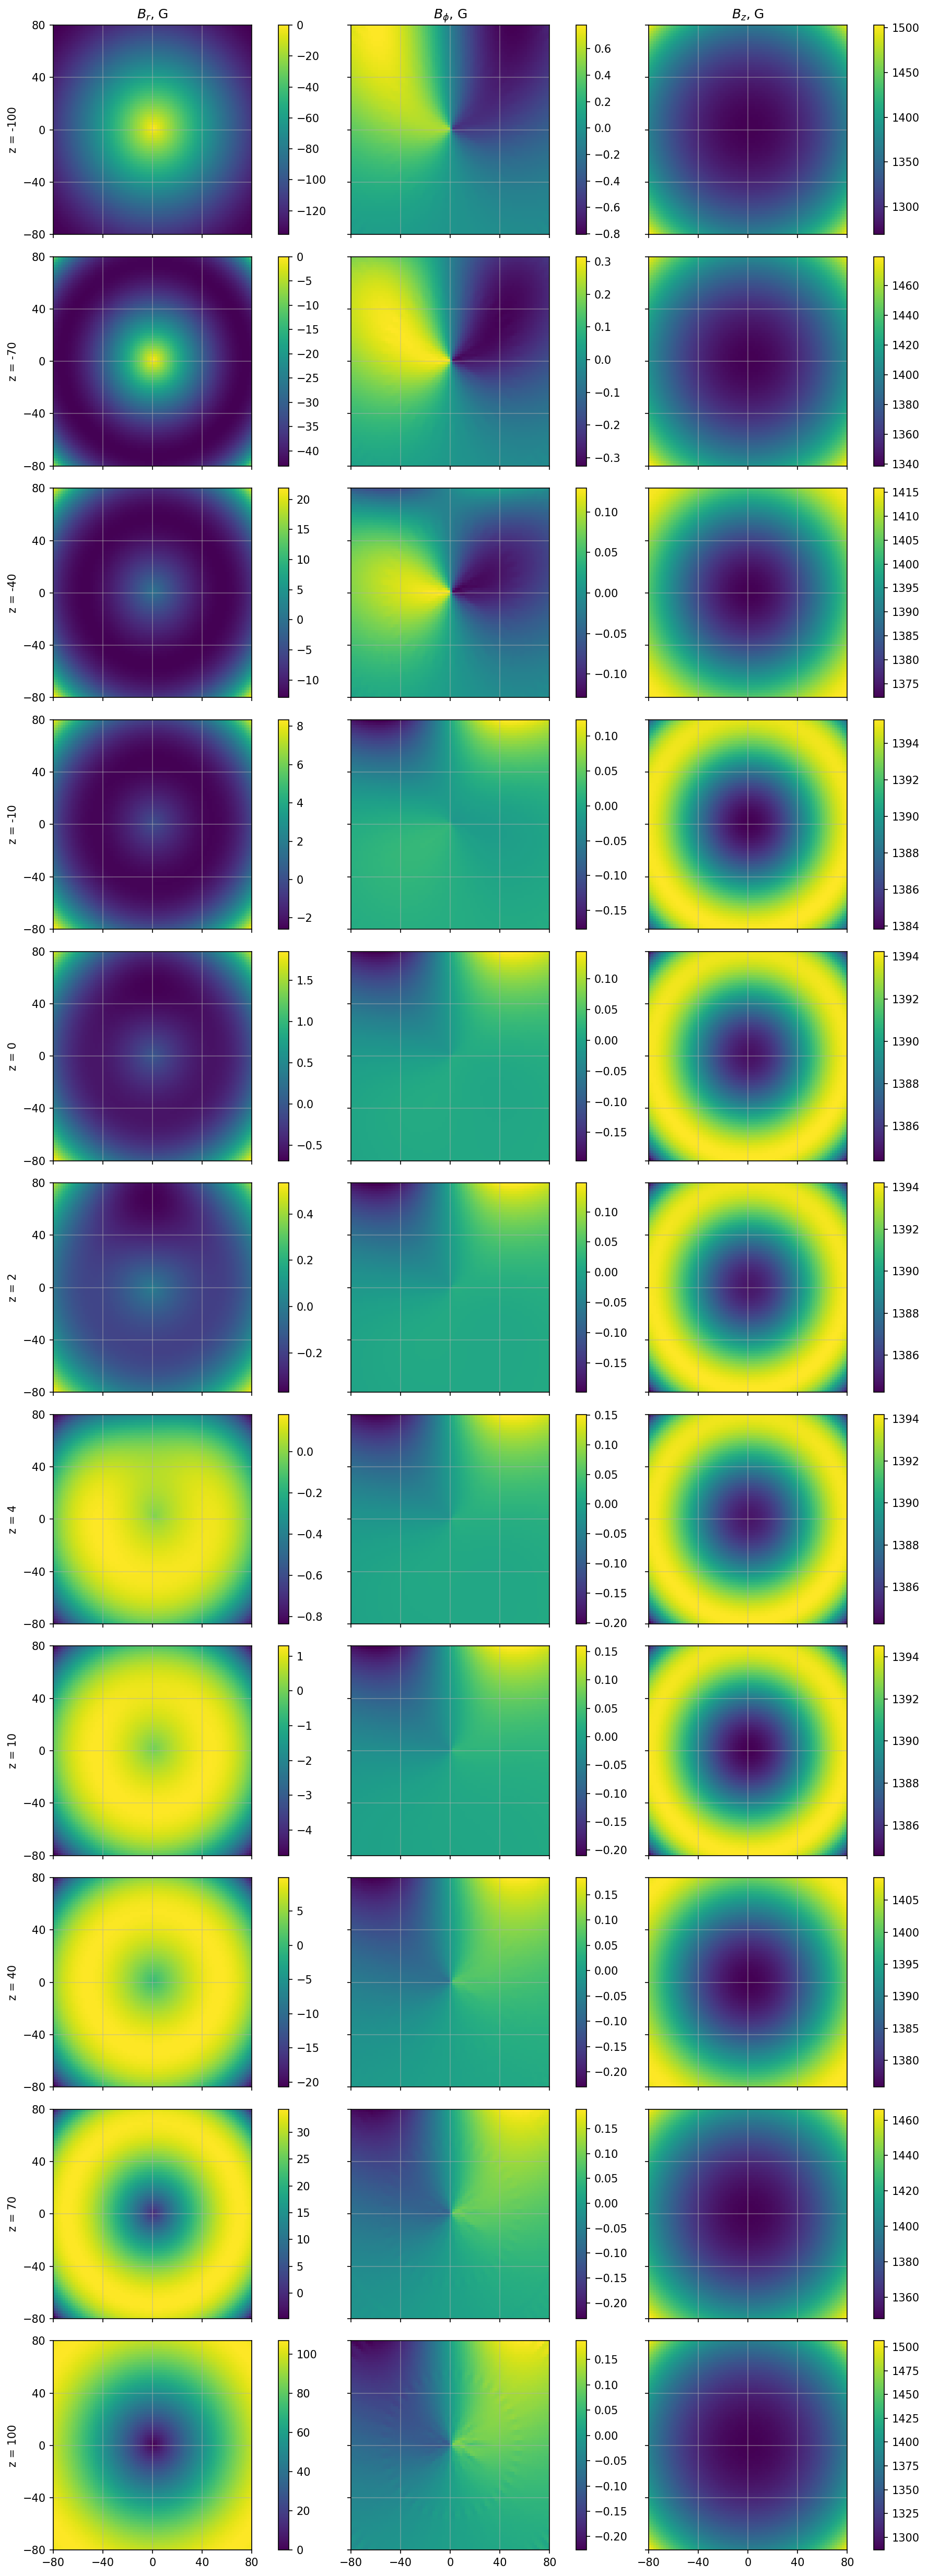

In [20]:
z_slices = [-100, -70, -40, -10, 0, 2, 4, 10, 40, 70, 100]
#z_slices = [-80, 0, 80]
columns = ['br', 'bp', 'bz']

dfc_ = dfc.sort_values(['y', 'x', 'z'])

fig = fig_field_components(dfc_, False, z_slices, columns, axsize=(4,3))
fig.tight_layout()
plt.show()

In [21]:
indexer = (dfc.z == 0)
df_slice = dfc.loc[indexer]

In [22]:
x = np.linspace(-80, 80, 81)
y = np.linspace(-80, 80, 81)
z = np.linspace(-100, 100, 101)

#xx, yy = np.meshgrid(x, y)
#plt.pcolormesh(xx, yy, df_slice.bz.values.reshape(81,81))
#plt.colorbar()

interp_bx = RegularGridInterpolator((x, y, z), dfc.bx.values.reshape(81, 81, 101))
interp_by = RegularGridInterpolator((x, y, z), dfc.by.values.reshape(81, 81, 101))
interp_bz = RegularGridInterpolator((x, y, z), dfc.bz.values.reshape(81, 81, 101))

Define new binning and the order (r,z,phi) of the axes

In [23]:
p = np.linspace(0, 360, 145)
z = np.linspace(-100, 100, 101)
r = np.linspace(0, 80, 81)

pp, zz, rr = np.meshgrid(p, z, r)
#r#, zz, pp

Define points in (r, z, phi) at which the field will be evaluated be interpolation

In [24]:
coords = np.dstack(( rr.reshape(-1), zz.reshape(-1), pp.reshape(-1) )).reshape(-1,3)
#coords

In [25]:
df_new = pd.DataFrame(coords, columns=['r', 'z', 'p'])
#df_new

In [26]:
dfc_new = df_new.assign(**{
    'x': df_new.r * np.cos( df_new.p/180*np.pi ),
    'y': df_new.r * np.sin( df_new.p/180*np.pi ),
    'p': df_new.p/180 * np.pi,
})

#dfc_new = dfc_new.round(3)
#dfc_new

In [27]:
#plt.polar(dfc_new.phi/180*np.pi, dfc_new.r, '.', ms=1)
#plt.plot(dfc_new.x, dfc_new.y, '.', ms=1)
#plt.plot(dfc_new.y, '.', ms=1)

In [28]:
dfc_new = dfc_new.assign(**{
    'bx': interp_bx(np.dstack((dfc_new.x, dfc_new.y, dfc_new.z)).reshape(-1,3)),
    'by': interp_by(np.dstack((dfc_new.x, dfc_new.y, dfc_new.z)).reshape(-1,3)),
    'bz': interp_bz(np.dstack((dfc_new.x, dfc_new.y, dfc_new.z)).reshape(-1,3))
})

#dfc_new

In [29]:
dfc_new = dfc_new.assign(**{
    'br':  dfc_new.bx*np.cos(dfc_new.p) + dfc_new.by*np.sin(dfc_new.p),
    'bp': -dfc_new.bx*np.sin(dfc_new.p) + dfc_new.by*np.cos(dfc_new.p),
})

In [30]:
gb = dfc_new.groupby(['r', 'z'])

dfc_2d = gb.agg({'br': 'mean', 'bz': 'mean'}).reset_index()
dfc_2d.sort_values(['z', 'r'], inplace=True)
#dfc_2d

In [31]:
dfc_2d_str = dfc_2d.to_string(index=False, header=False, formatters={
    'r': '{:.1f}'.format,
    'z': '{:.1f}'.format,
    'br': '{:.3f}'.format,
    'bz': '{:.3f}'.format,
})

with open('sphenix3dmaprhophiz_2d.dat', 'w') as dat_file:
    print(dfc_2d_str, file=dat_file)

In [32]:
#dfc_new_s = dfc_new.sort_values(['r', 'z', 'phi'])
#dfc_new.sort_values(['phi', 'z', 'r'])

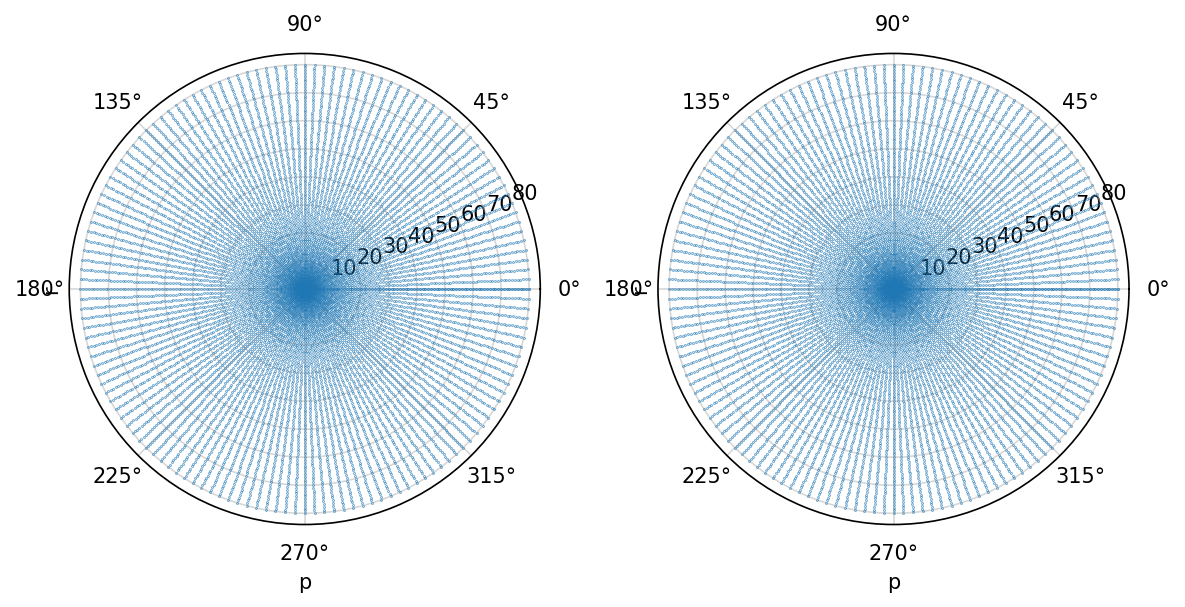

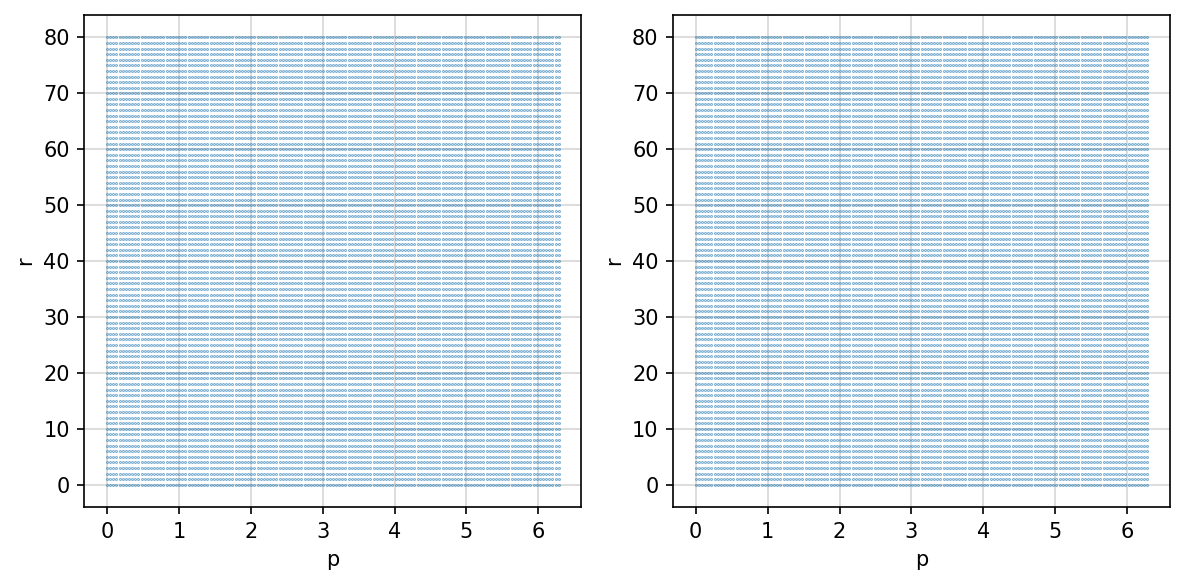

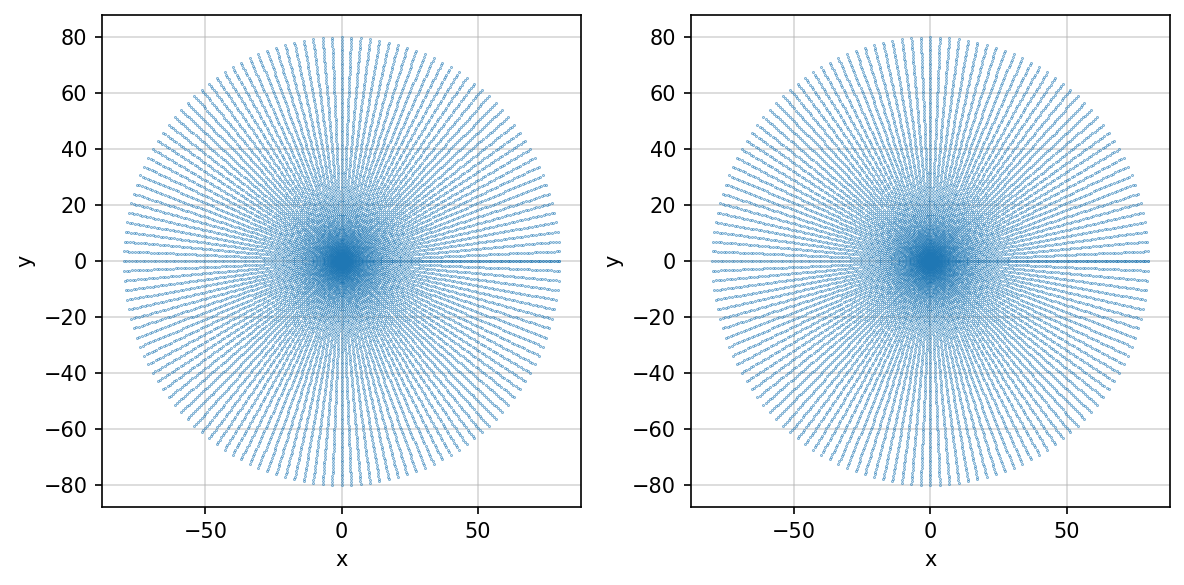

In [33]:
plot_slices(dfc_new, [-10, 10])

In [34]:
#dfc_new
dfc_new = dfc_new.sort_values(['r', 'p', 'z'])

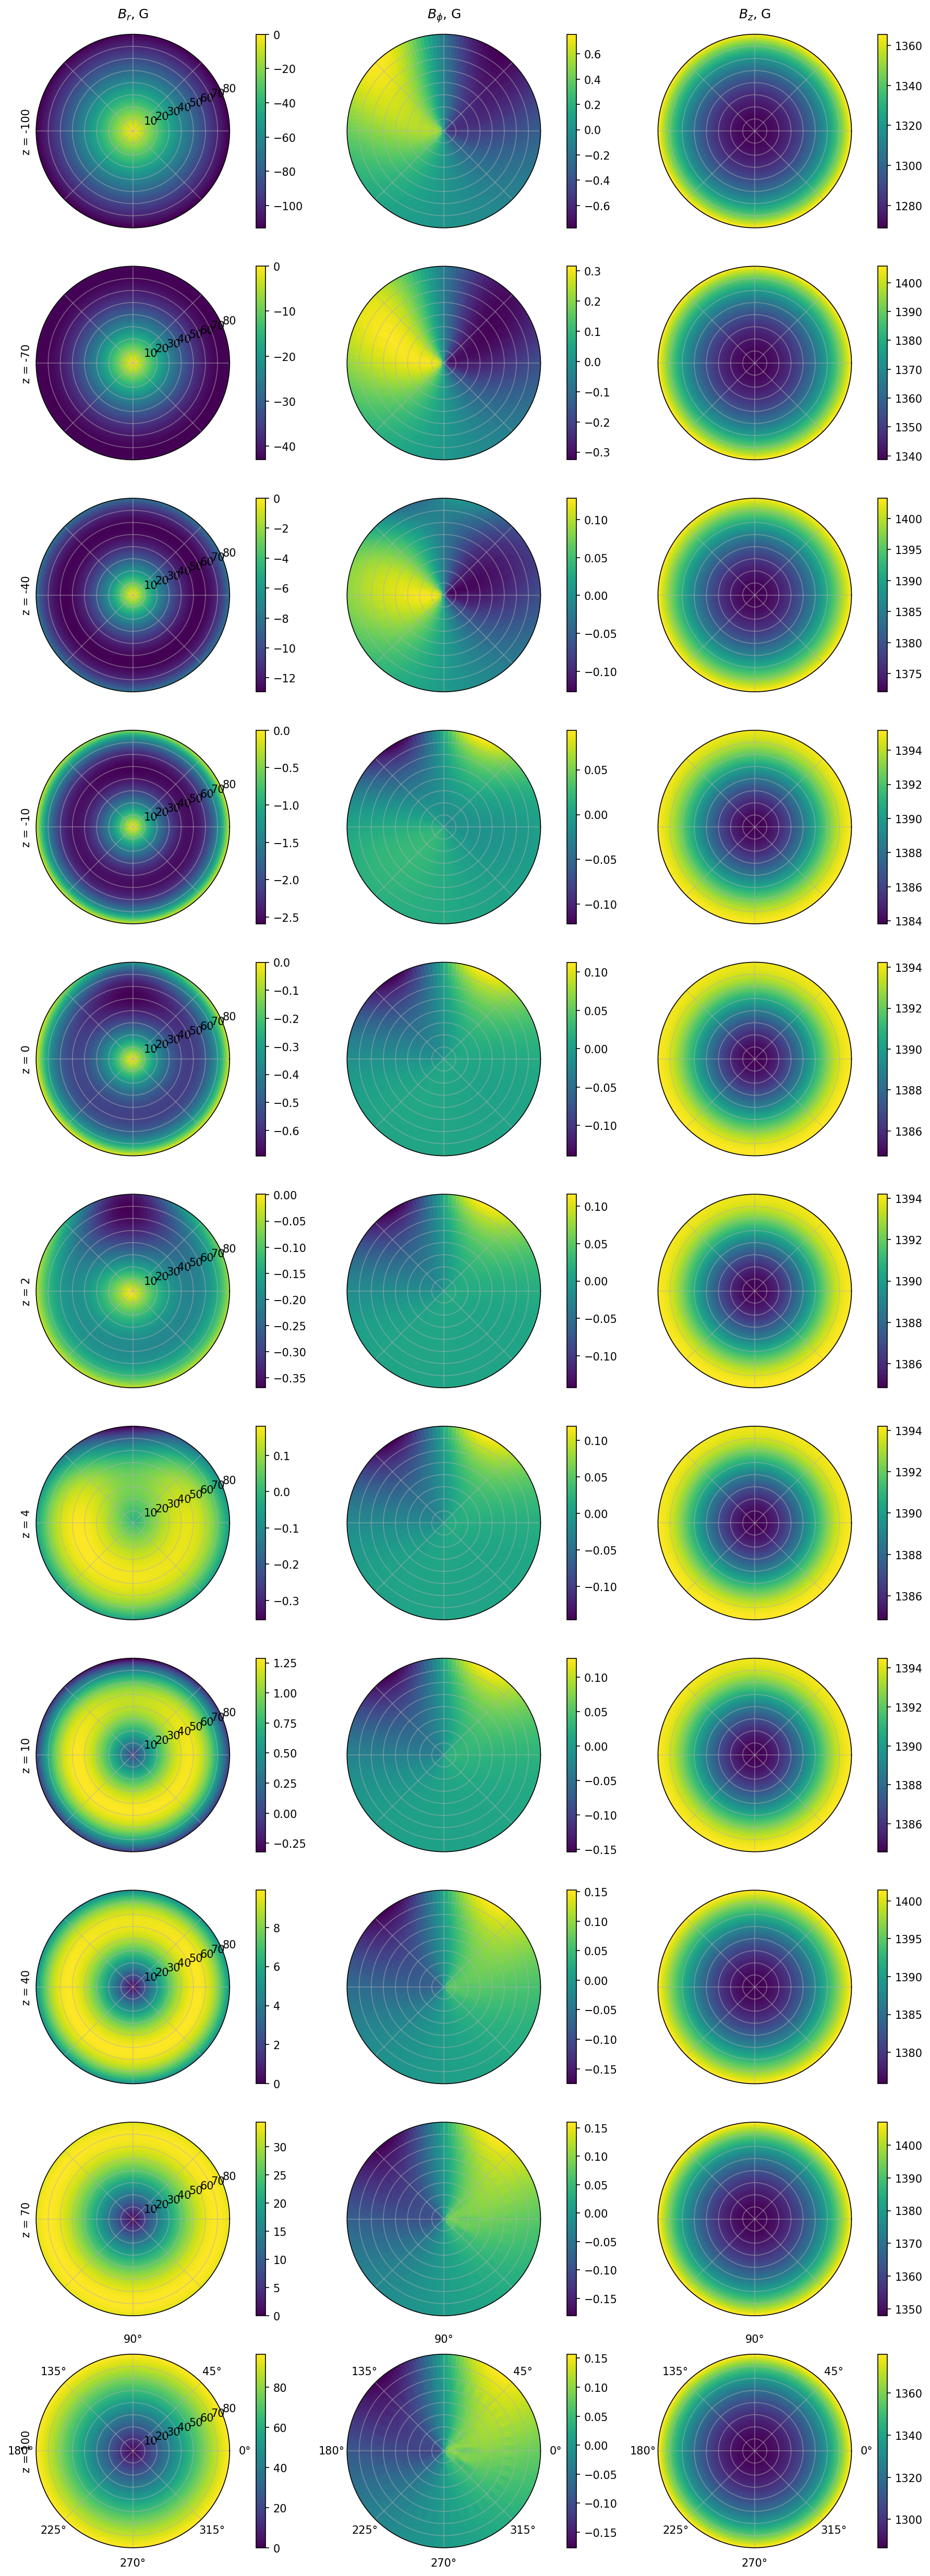

In [35]:
z_slices = [-100, -70, -40, -10, 0, 2, 4, 10, 40, 70, 100]
#z_slices = [-80, 0, 80]
columns = ['br', 'bp', 'bz']

fig = fig_field_components(dfc_new, True, z_slices, columns, axsize=(4,3))
fig.tight_layout()
plt.show()